# 2D Nonlinear Convection

* Jax-ify
* Don't Reinvent the Wheel

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import numpy as np
import numba as nb
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from jaxsw._src.domain.base import Domain
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

Let's start with a simple 2D Linear Advection scheme. This PDE is defined as:

$$
\begin{aligned}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} &= 0 \\
\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} &= 0 
\end{aligned}
$$ (eq:2dnadvection)

## Domain

In [2]:
nx, ny = 101, 101
xmin, ymin = 0.0, 0.0
xmax, ymax = 2.0, 2.0

In [3]:
domain = Domain.from_numpoints(xmin=(xmin, ymin), xmax=(xmax, ymax), N=(nx, ny))

print(f"Size: {domain.size}")
print(f"nDims: {domain.ndim}")
print(f"Grid Size: {domain.grid.shape}")
print(f"Cell Volume: {domain.cell_volume}")

Size: (100, 100)
nDims: 2
Grid Size: (100, 100, 2)
Cell Volume: 0.0004


### Initial Conditions

$$
\begin{aligned}
\mathcal{IC}[u],\mathcal{IC}[v] &=
\begin{cases}
2 && \text{for }x,y \in (0.5, 1)\times(0.5,1) \\
1 && \text{everywhere else}
\end{cases}
\end{aligned}
$$

In [4]:
def init_hat(domain: Domain) -> Array:
    dx, dy = domain.dx[0], domain.dx[0]
    nx, ny = domain.size[0], domain.size[1]

    u = jnp.ones((nx, ny))

    u = u.at[int(0.5 / dx) : int(1 / dx + 1), int(0.5 / dy) : int(1 / dy + 1)].set(2.0)

    return u


def fin_bump(x: Array) -> Array:
    if x <= 0 or x >= 1:
        return 0
    else:
        return 100 * jnp.exp(-1.0 / (x - np.power(x, 2.0)))


def init_smooth(domain: Domain) -> Array:
    dx, dy = domain.dx[0], domain.dx[0]
    nx, ny = domain.size[0], domain.size[1]

    u = jnp.ones((nx, ny))

    for ix in range(nx):
        for iy in range(ny):
            x = ix * dx
            y = iy * dy
            u = u.at[ix, iy].set(fin_bump(x / 1.5) * fin_bump(y / 1.5) + 1.0)

    return u

In [5]:
# initialize field to be zero
# u_init = init_hat(nx, ny, dx, dy)
u_init_hat = init_hat(domain)
# u_init_smooth = init_smooth(domain)

In [6]:
grid = domain.grid

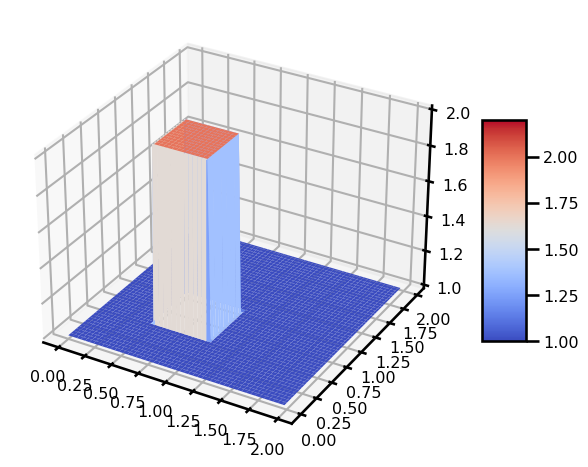

In [7]:
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(
    grid[..., 0],
    grid[..., 1],
    u_init_hat,
    cmap=cm.coolwarm,
    vmin=u_init_hat.min(),
    vmax=u_init_hat.max() + 0.1 * u_init_hat.max(),
)
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

# from matplotlib import cm

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# surf = ax.plot_surface(grid[...,0], grid[...,1], u_init_smooth,
#                        cmap=cm.coolwarm,
#                        vmin=u.min(), vmax=u.max()+0.1*u.max())
# plt.colorbar(surf, shrink=0.5, aspect=5)
# plt.tight_layout()
# plt.show()

### Boundary Conditions

$$
\begin{aligned}
\mathcal{BC}[u](\mathbf{x}) = \mathcal{BC}[v](\mathbf{x})&= 1 
&& && \mathbf{x}\in\partial\Omega
\end{aligned}
$$

In [8]:
def bc_fn(u: Array) -> Array:
    u = u.at[0, :].set(1.0)
    u = u.at[-1, :].set(1.0)
    u = u.at[:, 0].set(1.0)
    u = u.at[:, -1].set(1.0)
    return u

### Equation of Motion

Because we are doing advection, we will use backwards difference for each of the terms.

$$
\begin{aligned}
D^-_x[u] &:= \frac{\partial u}{\partial x} \\
D^-_y[u] &:= \frac{\partial u}{\partial y}  \\
D^-_x[v] &:= \frac{\partial v}{\partial x} \\
D^-_y[v] &:= \frac{\partial v}{\partial y}  \\
\end{aligned}
$$ (eq:2dnadvection)

where $D^-$ is the backwards different finite difference method.

In [9]:
from typing import Optional
from jaxsw._src.operators.functional import advection


class NonLinearConvection2D(DynamicalSystem):
    @staticmethod
    def equation_of_motion(t: float, u: Array, args):
        # parse inputs
        u, v = u

        domain = args

        # apply boundary conditions
        u = bc_fn(u)
        v = bc_fn(v)

        # apply naive advection schemes
        u_rhs = advection.advection_2D(u=u, a=u, b=v, step_size=domain.dx, accuracy=1)
        v_rhs = advection.advection_2D(u=v, a=u, b=v, step_size=domain.dx, accuracy=1)

        return -u_rhs, -v_rhs

In [10]:
# SPATIAL DISCRETIZATION
u = init_hat(domain)
v = init_hat(domain)

u_init = (u, v)

out = NonLinearConvection2D.equation_of_motion(0, u_init, domain)


out[0].min(), out[0].max(), out[1].min(), out[1].max()

(Array(-200., dtype=float64),
 Array(50., dtype=float64),
 Array(-200., dtype=float64),
 Array(50., dtype=float64))

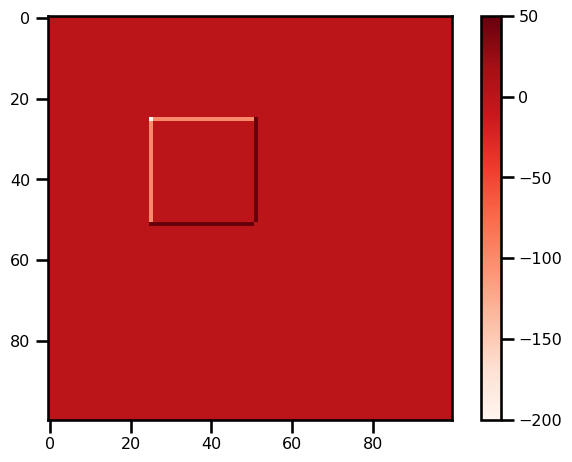

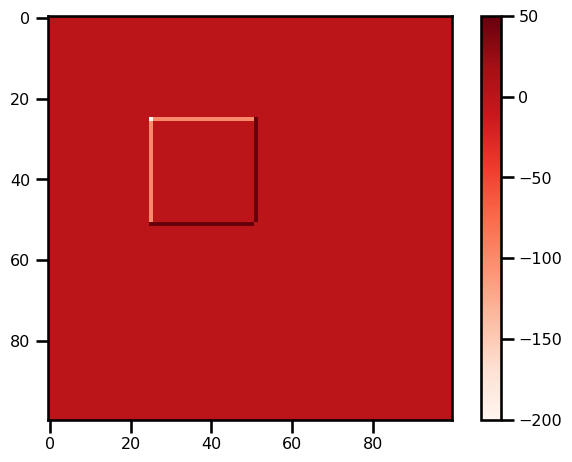

In [11]:
fig, ax = plt.subplots()
pts = ax.imshow(out[0], cmap="Reds")
plt.colorbar(pts)
plt.tight_layout()
plt.show()
fig, ax = plt.subplots()
pts = ax.imshow(out[1], cmap="Reds")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

## Time Stepping

In [12]:
# TEMPORAL DISCRETIZATION
# initialize temporal domain
tmin = 0.0
tmax = 0.5
num_save = 50

#### CFD Condition

In [13]:
# CFL condition
def cfl_cond(dx, c, sigma):
    assert sigma <= 1.0
    return (sigma * dx) / c

In [14]:
# temporal parameters
c = 1.0
sigma = 0.2
dt = cfl_cond(dx=domain.dx[0], c=c, sigma=sigma)

In [15]:
t_domain = TimeDomain(tmin=tmin, tmax=tmax, dt=dt)
ts = jnp.linspace(tmin, tmax, num_save)
saveat = dfx.SaveAt(ts=ts)

# DYNAMICAL SYSTEM
dyn_model = NonLinearConvection2D(t_domain=t_domain, saveat=saveat)

### Integration

In [16]:
# Euler, Constant StepSize
solver = dfx.Euler()
stepsize_controller = dfx.ConstantStepSize()

# SPATIAL DISCRETIZATION
u = init_hat(domain)
v = init_hat(domain)

u_init = (u, v)


# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(dyn_model.equation_of_motion),
    solver=solver,
    t0=ts.min(),
    t1=ts.max(),
    dt0=dt,
    y0=u_init,
    saveat=saveat,
    args=domain,
    stepsize_controller=stepsize_controller,
)

## Analysis

In [17]:
da_sol = xr.Dataset(
    data_vars={
        "u": (("time", "x", "y"), np.asarray(sol.ys[0])),
        "v": (("time", "x", "y"), np.asarray(sol.ys[1])),
    },
    coords={
        "x": (["x"], np.asarray(domain.coords[0])),
        "y": (["y"], np.asarray(domain.coords[1])),
        "time": (["time"], np.asarray(sol.ts)),
    },
    attrs={"pde": "nonlinear_convection", "sigma": sigma},
)
da_sol

<xarray.Dataset>
Dimensions:  (time: 50, x: 100, y: 100)
Coordinates:
  * x        (x) float64 0.0 0.02 0.04 0.06 0.08 0.1 ... 1.9 1.92 1.94 1.96 1.98
  * y        (y) float64 0.0 0.02 0.04 0.06 0.08 0.1 ... 1.9 1.92 1.94 1.96 1.98
  * time     (time) float64 0.0 0.0102 0.02041 0.03061 ... 0.4796 0.4898 0.5
Data variables:
    u        (time, x, y) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    v        (time, x, y) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    pde:      nonlinear_convection
    sigma:    0.2

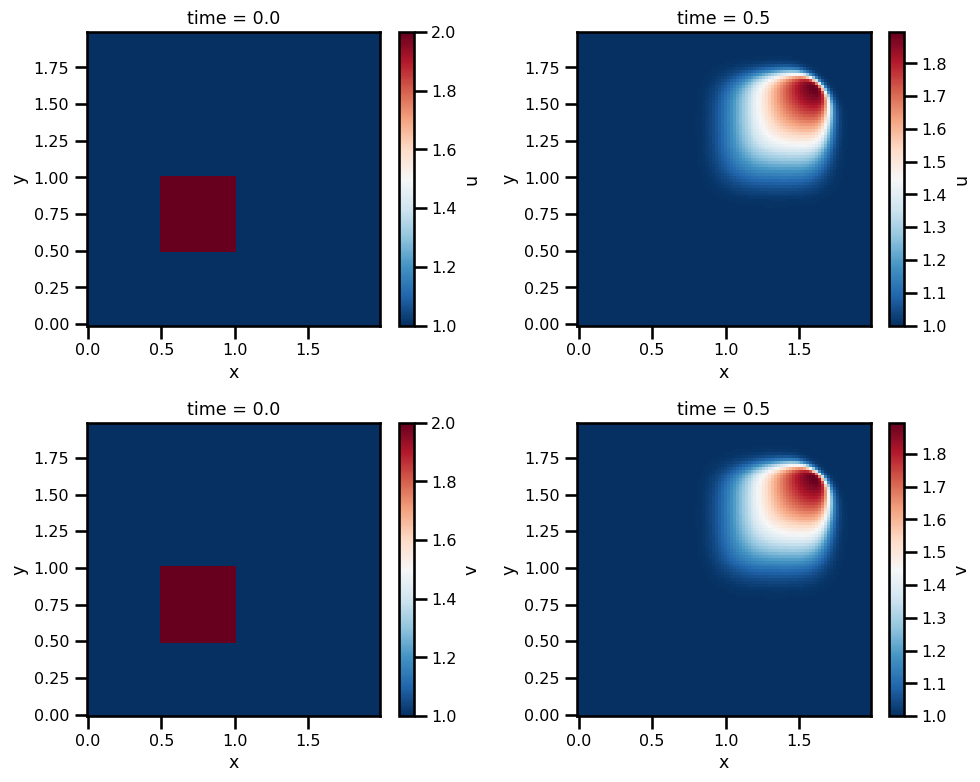

In [18]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))

# U
da_sol.u.isel(time=0).T.plot.pcolormesh(ax=ax[0, 0], cmap="RdBu_r")
da_sol.u.isel(time=-1).T.plot.pcolormesh(ax=ax[0, 1], cmap="RdBu_r")

# V
da_sol.v.isel(time=0).T.plot.pcolormesh(ax=ax[1, 0], cmap="RdBu_r")
da_sol.v.isel(time=-1).T.plot.pcolormesh(ax=ax[1, 1], cmap="RdBu_r")

plt.tight_layout()
plt.show()

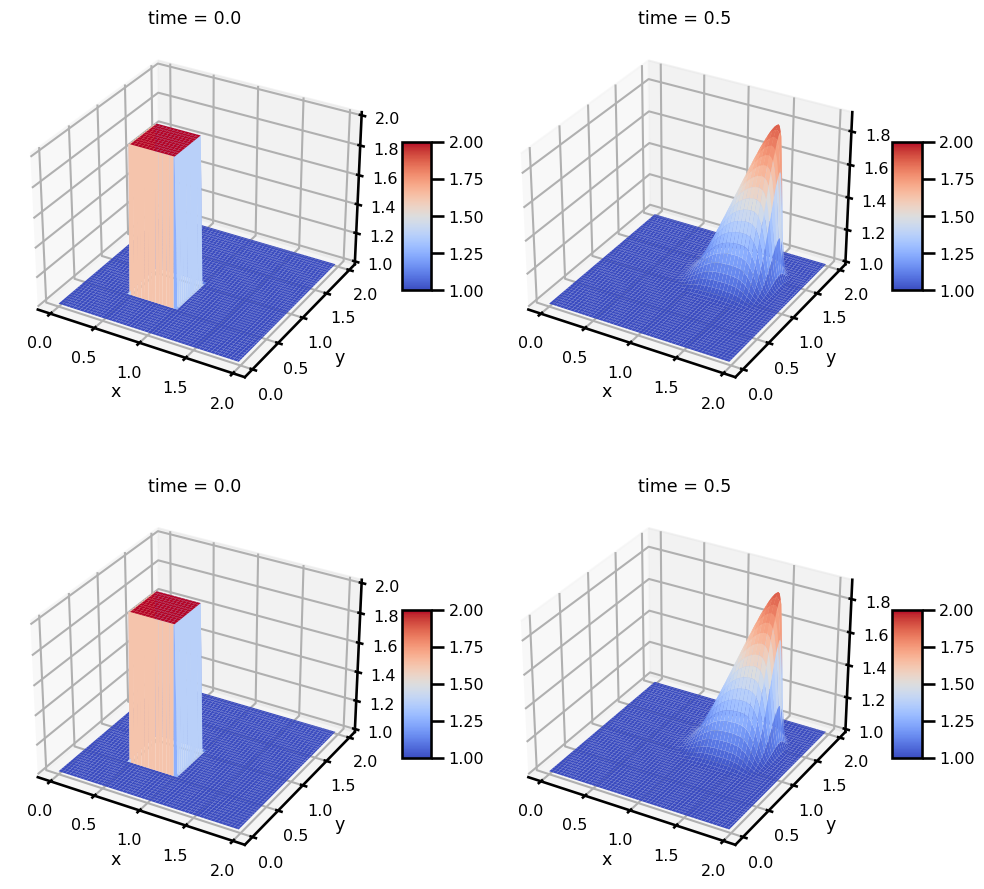

In [19]:
fig, ax = plt.subplots(
    ncols=2, nrows=2, subplot_kw={"projection": "3d"}, figsize=(10, 10)
)

vmin = da_sol.min()
vmax = da_sol.max()

cbar_kwargs = dict(shrink=0.3, aspect=5)

# U
vmin = da_sol.u.min()
vmax = da_sol.u.max()

pts = da_sol.u.isel(time=0).T.plot.surface(
    ax=ax[0, 0], vmin=vmin, vmax=vmax, cmap="coolwarm", add_colorbar=False
)
plt.colorbar(pts, **cbar_kwargs)
pts = da_sol.u.isel(time=-1).T.plot.surface(
    ax=ax[0, 1], vmin=vmin, vmax=vmax, cmap="coolwarm", add_colorbar=False
)
plt.colorbar(pts, **cbar_kwargs)

# V
vmin = da_sol.v.min()
vmax = da_sol.v.max()
pts = da_sol.v.isel(time=0).T.plot.surface(
    ax=ax[1, 0], vmin=vmin, vmax=vmax, cmap="coolwarm", add_colorbar=False
)
plt.colorbar(pts, **cbar_kwargs)
pts = da_sol.v.isel(time=-1).T.plot.surface(
    ax=ax[1, 1], vmin=vmin, vmax=vmax, cmap="coolwarm", add_colorbar=False
)
plt.colorbar(pts, **cbar_kwargs)
plt.tight_layout()
plt.show()